Reference: https://keras.io/examples/generative/ddim/

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import layers
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras.optimizers import Adam
from keras.losses import mean_absolute_error
import cv2

In [2]:
# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

optimizer = Adam(0.0002, 0.5)

In [3]:
batch_size = 8
image_size = 256
channels = 1

def preprocessing_function(image):
    image = image.astype(float) / 255
    return image

idg = ImageDataGenerator(preprocessing_function = preprocessing_function)
heightmap_iterator = idg.flow_from_directory('../../heightmaps/uncorrupted_split_heightmaps_second_pass', 
                                             target_size = (image_size, image_size), 
                                             batch_size = batch_size,
                                             color_mode = 'grayscale',
                                             classes = [''])

Found 582569 images belonging to 1 classes.


In [4]:
def show_images(images, rows, columns):
    i = 0
    f, axs = plt.subplots(rows, columns, figsize=(100,35))
    for x in axs.flatten():
        x.imshow(images[i], cmap='gray')
        x.axis('off')
        i += 1
    plt.tight_layout()
    plt.show()

In [5]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    #angular_speeds = tf.cast(angular_speeds, tf.float16)
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

In [6]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

In [7]:
def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply

In [8]:
def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [9]:
def create_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, channels))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(channels, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")

In [10]:
def diffusion_schedule(diffusion_times):
    # diffusion times -> angles
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    # angles -> signal and noise rates
    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

In [5]:
def display_first_ten(displayTensor, name):
    print(name)
    for i in range(10):
        print(float(displayTensor[0][0][i][0]))
    print('\n')

In [30]:
def reverse_diffusion(model, num_images, diffusion_steps):
    step_size = 1.0 / diffusion_steps
    
    next_noisy_images = initial_noise
    display_first_ten(next_noisy_images, 'next_noisy_images')
    for step in range(diffusion_steps):
        noisy_images = next_noisy_images
        display_first_ten(noisy_images, 'noisy_images')
        
        diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
        noise_rates, signal_rates = diffusion_schedule(diffusion_times)
        print("\n")
        print("noise_rate", float(noise_rates[0]))
        print("signal_rate", float(signal_rates[0]))
        print("\n")
        
        #pred_noises = model.predict([noisy_images, noise_rates**2])
        pred_noises = model([noisy_images, noise_rates**2], training = True)
        display_first_ten(pred_noises, 'pred_noises')
        display_first_ten(noise_rates * pred_noises, 'noise_rates * pred_noises')
        display_first_ten(noisy_images - noise_rates * pred_noises, 'noisy_images - noise_rates * pred_noises')
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        display_first_ten(pred_images, 'pred_images')
        
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = diffusion_schedule(next_diffusion_times)
        next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
        
    return pred_images

In [31]:
generated_images = reverse_diffusion(network, 1, 1)

next_noisy_images
0.9011194109916687
0.6195852756500244
-0.6117985248565674
2.4007930755615234
-0.5817896723747253
-0.8494806289672852
0.39821305871009827
0.43850618600845337
0.6848859786987305
-1.8536479473114014


noisy_images
0.9011194109916687
0.6195852756500244
-0.6117985248565674
2.4007930755615234
-0.5817896723747253
-0.8494806289672852
0.39821305871009827
0.43850618600845337
0.6848859786987305
-1.8536479473114014




noise_rate 0.9997999668121338
signal_rate 0.020000034943223


pred_noises
0.9152868390083313
0.6205334067344666
-0.6750975847244263
2.4954731464385986
-0.6306686401367188
-0.9042479991912842
0.4082490801811218
0.45031216740608215
0.7037951946258545
-1.943964958190918


noise_rates * pred_noises
0.9151037335395813
0.6204092502593994
-0.6749625205993652
2.49497389793396
-0.6305424571037292
-0.9040670990943909
0.40816742181777954
0.45022210478782654
0.703654408454895
-1.9435760974884033


noisy_images - noise_rates * pred_noises
-0.013984322547912598
-0.00082397460937

In [3]:
initial_noise = tf.random.normal(shape=(1, 256, 256, 1))

In [6]:
display_first_ten(initial_noise, "initial_noise")

initial_noise
-0.273124635219574
-1.0940667390823364
0.07306116074323654
0.39168035984039307
-0.2542717158794403
-0.5545506477355957
1.130194067955017
-0.5099871754646301
0.40075168013572693
0.4942871332168579




In [14]:
flattened_noise = initial_noise.numpy().reshape((image_size * image_size))
tensor_string = "public float[] tensorArray = {"
for i in range(flattened_noise.shape[0] - 1):
    tensor_string += str(flattened_noise[i]) + "f, "
tensor_string += str(flattened_noise[flattened_noise.shape[0] - 1]) + "f"
tensor_string += "};"
print(tensor_string)

public float[] tensorArray = {0.9011194f, 0.6195853f, -0.6117985f, 2.400793f, -0.5817897f, -0.8494806f, 0.39821306f, 0.4385062f, 0.684886f, -1.853648f, 0.0830616f, -1.3533524f, -1.0618972f, -1.2298882f, 0.4699696f, -0.25725994f, -0.47277287f, -0.79884f, 0.043694444f, -0.459418f, 0.4610294f, 0.103920184f, 0.1802531f, -0.5689376f, 1.2759967f, -2.7121775f, 1.5813076f, 0.9317364f, -0.91100377f, -0.149115f, 0.67457515f, -0.10193744f, -0.32559684f, -0.08584726f, -1.0107825f, -0.7738663f, 1.1596935f, 0.7933851f, 1.2478205f, -0.77165055f, 0.26363453f, -1.3576921f, 0.030312056f, 0.47659573f, 0.35193405f, -2.422252f, 1.1416763f, 0.3136698f, 2.2738962f, 0.57934195f, 0.8410631f, -1.4464263f, -0.050347663f, -0.47267374f, 0.3068768f, -0.72900283f, -0.44293872f, -1.3045657f, 0.521332f, 0.08194248f, -1.0061975f, 0.47274378f, -1.0586517f, -0.5583674f, -0.481046f, -0.47461292f, -0.75512546f, 0.28600013f, 0.9461302f, -1.8461201f, 0.23165579f, 0.71390635f, 0.6588686f, 0.7967206f, 0.3800712f, 1.3869624f, 0

In [40]:
def train(directory_iterator, model, epochs):
    directory_iterator.reset()
    steps_per_epoch = directory_iterator.__len__() - 1
    
    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            images = np.asarray(directory_iterator.next()[0])
            if images.shape[0] != batch_size:
                continue
                
            noises = tf.random.normal(shape=(batch_size, image_size, image_size, channels))

            diffusion_times = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0)
            noise_rates, signal_rates = diffusion_schedule(diffusion_times)

            noisy_images = signal_rates * images + noise_rates * noises
            model.train_on_batch([noisy_images, noise_rates**2], noises)
            
        print('Epoch ' + str(57 + epoch + 1) + ' completed.')
        model.save('../data/models/diffusion_models/diffusion1_epoch' + str(57 + epoch + 1))
        generated_images = reverse_diffusion(network, num_images = 7, diffusion_steps = 20)
        show_images(generated_images, rows = 1, columns = 7)
    
    return model

In [34]:
#network = create_network(image_size, widths, block_depth)
#network.compile(optimizer = optimizer, loss = mean_absolute_error)

In [16]:
network = keras.models.load_model('../data/models/diffusion_models/diffusion1_epoch62')

In [45]:
generated_images = reverse_diffusion(network, 1, 1)

(65536,)
a


In [ ]:
network = train(heightmap_iterator, network, 10)

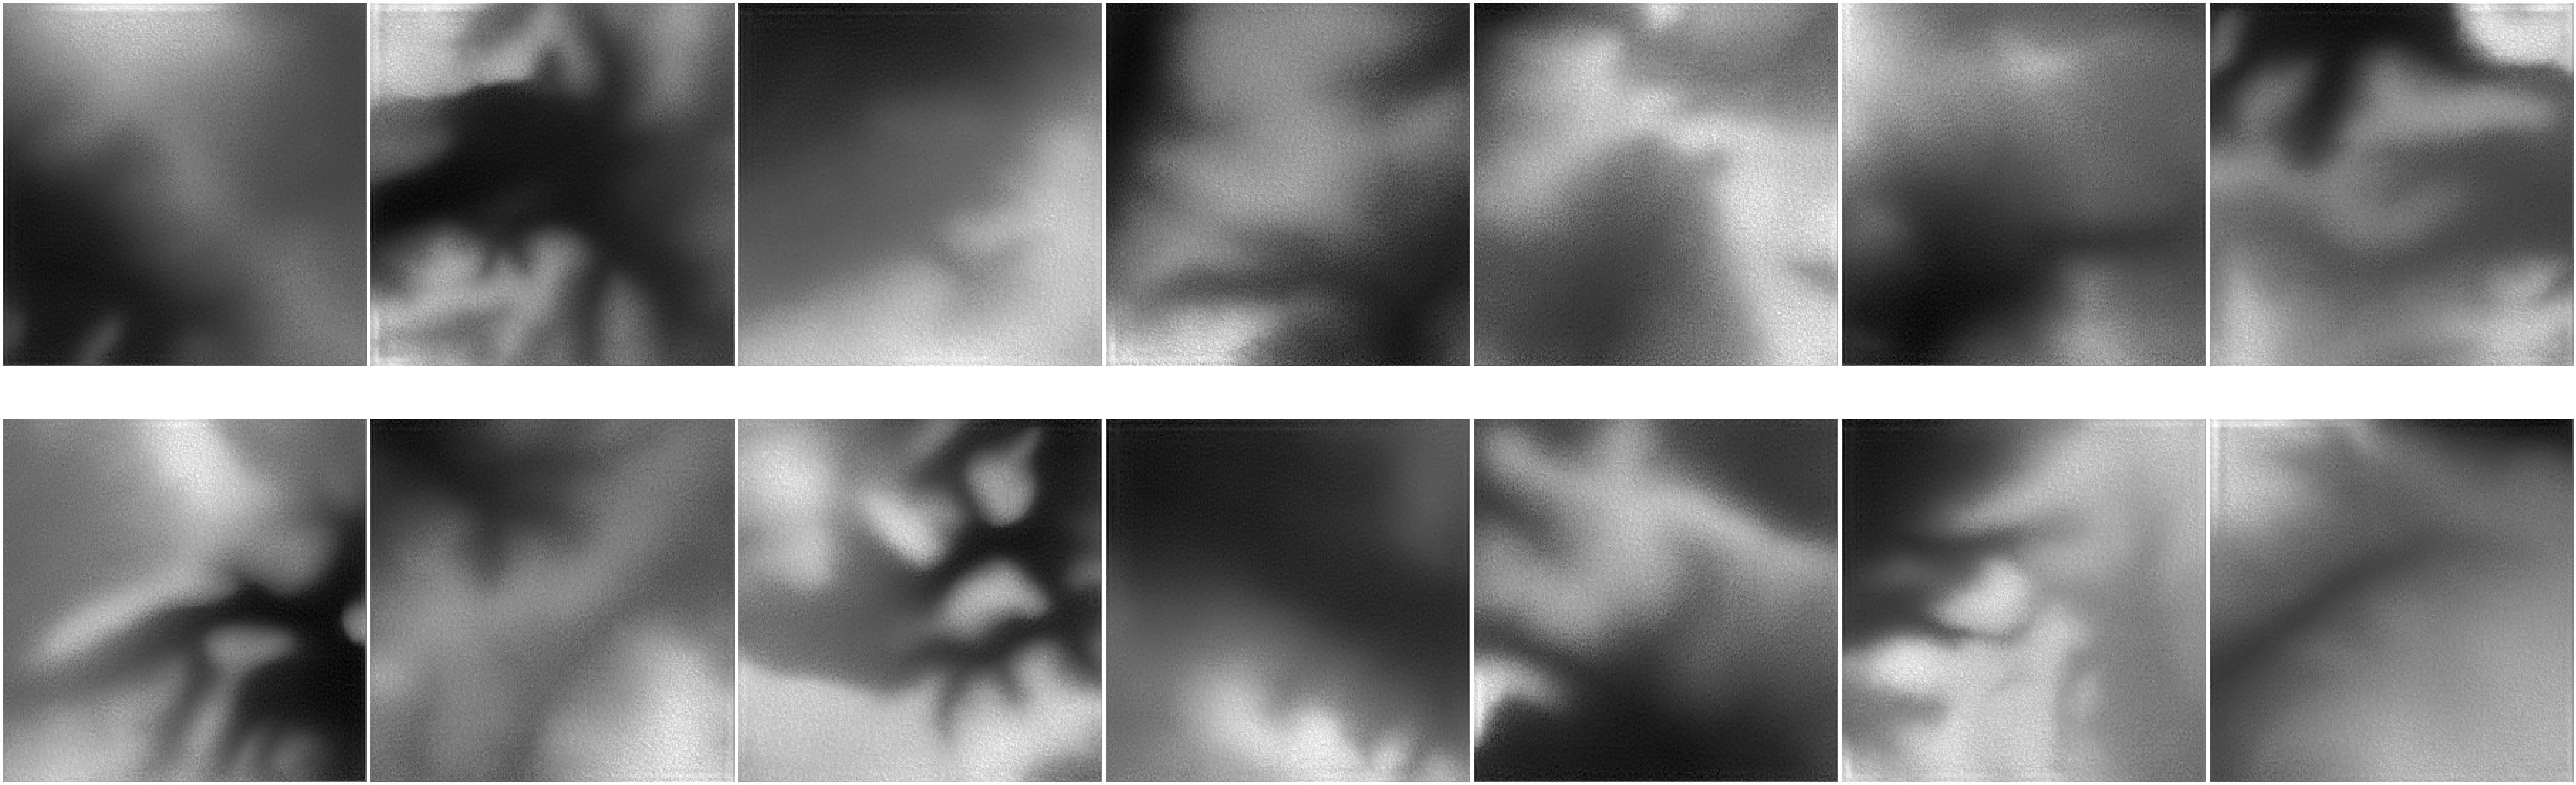

In [16]:
generated_images = reverse_diffusion(network, num_images = 14, diffusion_steps = 20)
show_images(generated_images, rows = 2, columns = 7)

In [20]:
generated_images[0]

<tf.Tensor: shape=(256, 256, 1), dtype=float32, numpy=
array([[[ 0.43652105],
        [ 0.45665452],
        [ 0.48454663],
        ...,
        [-0.01719279],
        [-0.00434291],
        [ 0.04235736]],

       [[ 0.46820948],
        [ 0.3868093 ],
        [ 0.48263288],
        ...,
        [-0.14147216],
        [-0.05231573],
        [ 0.08657069]],

       [[ 0.40978536],
        [ 0.43289125],
        [ 0.45583516],
        ...,
        [ 0.02334288],
        [ 0.01057109],
        [ 0.12728032]],

       ...,

       [[-0.20185086],
        [-0.3744367 ],
        [-0.27453426],
        ...,
        [ 0.24232621],
        [ 0.36625063],
        [ 0.26285103]],

       [[-0.03139983],
        [-0.40270558],
        [-0.2862837 ],
        ...,
        [ 0.31085095],
        [ 0.3724712 ],
        [ 0.3027153 ]],

       [[ 0.0660714 ],
        [ 0.04136216],
        [ 0.0443434 ],
        ...,
        [ 0.38311228],
        [ 0.30877653],
        [ 0.33229637]]], dtype=float32)

# Diffusion Blending

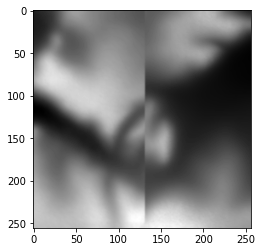

In [21]:
test_image = cv2.imread('data/diffusion_blend_test_image.png', 0)
plt.imshow(test_image, cmap='gray')

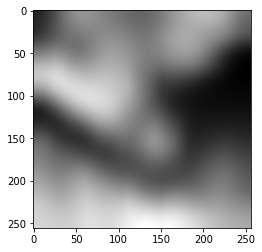

In [22]:
blurred_image = cv2.blur(test_image, (40, 40))
test_image = np.asarray(blurred_image)
test_image = test_image.reshape((1, image_size, image_size, channels))
plt.imshow(test_image[0], cmap='gray')

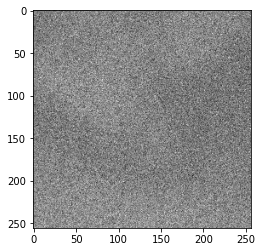

In [31]:
test_noise = tf.random.normal(shape=(1, image_size, image_size, channels))
signal_rate = 0.005
noise_rate = 1
noisy_image = signal_rate * test_image + noise_rate * test_noise
plt.imshow(noisy_image[0], cmap='gray')

In [32]:
def image_to_image(model, images, num_images, diffusion_steps, starting_step):
    step_size = 1.0 / diffusion_steps
    
    next_noisy_images = images
    for step in range(diffusion_steps - starting_step):
        noisy_images = next_noisy_images
        
        diffusion_times = tf.ones((num_images, 1, 1, 1)) - (step + starting_step) * step_size
        noise_rates, signal_rates = diffusion_schedule(diffusion_times)
        
        pred_noises = model([noisy_images, noise_rates**2], training = True)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = diffusion_schedule(next_diffusion_times)
        next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
    
    return pred_images

In [33]:
blended_image = image_to_image(network, images = noisy_image, num_images = 1, diffusion_steps = 20, starting_step = 0)

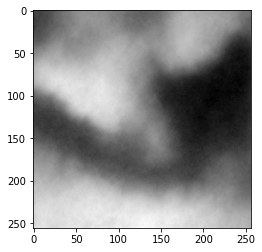

In [34]:
plt.imshow(blended_image[0], cmap='gray')